# Model Training

This notebook is used to train the processed crime data set on different models and compare the results.

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white")

## Methods

In [2]:
def createAndSaveLabelEncoder(data, column):
    '''
    function to create and save label encoder object for the given column.
    '''
    le = LabelEncoder()
    le.fit(data[column])
    with open('store/'+column+'_label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)
    data[column] = le.transform(data[column])
    return data

In [3]:
def loadLabelEncoder(column):
    '''
    function to load label encoder object for the given column.
    '''
    with open('store/'+column+'_label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    return le

In [4]:
def saveModel(model, name):
    '''
    function to save model object with the given name.
    '''
    with open('store/'+name+'_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print('%s Model saved successfully.' % name)

In [5]:
def tuneModel(model, parameters, X_train, y_train):
    '''
    function to tune the model to find best combination of parameters.
    '''
    tuner = GridSearchCV(model, parameters, n_jobs=-1)
    tuner.fit(X_train, y_train)
    return tuner.best_params_

In [6]:
def validateModel(model, X_train, y_train, target_names):
    '''
    function to validate the given model using the given parameters and display the report.
    '''
    y_val = cross_val_predict(model, X_train, y_train, cv=10, n_jobs=-1)
    print(classification_report(y_train, y_val, target_names=target_names))

In [7]:
def fitModel(model, parameters, X_train, y_train):
    model.set_params(**parameters)
    model.fit(X_train, y_train)
    return model

In [8]:
def evaluateModel(model, X_test, y_test, target_names):
    '''
    function to evaluated the given model using the given parameters and display the report.
    '''
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=target_names))

## Model

Get the processed data.

In [9]:
crime_data = pd.read_pickle('store/crime_data.pkl', compression='gzip')

Drop columns that do not need to be considered for classification model.

In [10]:
crime_data = crime_data.drop(['category', 'year'], axis=1)

Store the columns list.

In [11]:
columns = list(crime_data)

Label encode all the columns that require it.

In [12]:
cols = ['day', 'district', 'month', 'time_interval', 'label']
for col in cols:
    crime_data = createAndSaveLabelEncoder(crime_data, col)

Extract labels.

In [13]:
labels = crime_data['label']
crime_data = crime_data.drop('label', axis=1)

Split the train and test data sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(crime_data.values, labels, test_size=0.2, random_state=42, 
                                                    stratify=labels)

Define the KNeighborsClassifier model.

In [15]:
kNN_model = KNeighborsClassifier()

Define the RandomForestClassifier model.

In [16]:
randomForest_model = RandomForestClassifier()

Define the GaussianNB model.

In [17]:
gaussianNB_model = GaussianNB()

## Tuning

Tune the KNeighborsClassifier model.

In [18]:
kNN_parameters = {'n_neighbors': [3, 5, 10, 20, 50, 100, 120],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto'],
              'leaf_size': [30],
              'metric': ['euclidean'],
              'n_jobs': [-1]
             }
best_parameters = tuneModel(kNN_model, kNN_parameters, X_train, y_train)
kNN_model = fitModel(kNN_model, best_parameters, X_train, y_train)

# Best
# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean', 
#                   metric_params=None, n_jobs=-1, n_neighbors=100, p=2, weights='distance')

Tune the RandomForestClassifier model.

In [19]:
randomForest_parameters = {
    'n_jobs': [-1],
    'n_estimators': [5, 10, 20, 50, 100, 120],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [0],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'warm_start': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
best_parameters = tuneModel(randomForest_model, randomForest_parameters, X_train, y_train)
randomForest_model = fitModel(randomForest_model, best_parameters, X_train, y_train)

# Best
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
#           min_impurity_decrease=0.0, min_impurity_split=None,
#           min_samples_leaf=1, min_samples_split=2,
#           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
#           oob_score=False, random_state=0, verbose=0, warm_start=False)

Tune the GaussianNB model.

In [20]:
gaussianNB_parameters = {
              'priors': [None]
             }
best_parameters = tuneModel(gaussianNB_model, gaussianNB_model_parameters, X_train, y_train)
gaussianNB_model = fitModel(gaussianNB_model, best_parameters, X_train, y_train)

# Best
# GaussianNB(priors=None)

## Validation

In [21]:
target_names = ['high', 'low', 'moderate']

Validate the KNeighborsClassifier model.

In [22]:
validateModel(kNN_model, X_train, y_train, target_names)

Validate the RandomForestClassifier model.

In [23]:
validateModel(randomForest_model, X_train, y_train, target_names)

Validate the GaussianNB model.

In [24]:
validateModel(gaussianNB_model, X_train, y_train, target_names)

## Evaluation

Evaluate the KNeighborsClassifier model.

In [25]:
evaluateModel(kNN_model, X_test, y_test, target_names)

             precision    recall  f1-score   support

       high       0.77      0.88      0.82    262807
        low       0.52      0.39      0.45     89111
   moderate       0.30      0.11      0.17     27233

avg / total       0.67      0.71      0.68    379151



Evaluate the RandomForestClassifier model.

In [26]:
evaluateModel(randomForest_model, X_test, y_test, target_names)

             precision    recall  f1-score   support

       high       0.78      0.86      0.82    262807
        low       0.52      0.45      0.48     89111
   moderate       0.29      0.13      0.18     27233

avg / total       0.68      0.71      0.69    379151



Evaluate the GaussianNB model.

In [27]:
evaluateModel(gaussianNB_model, X_test, y_test, target_names)

             precision    recall  f1-score   support

       high       0.70      0.95      0.81    262807
        low       0.49      0.09      0.16     89111
   moderate       0.08      0.02      0.03     27233

avg / total       0.61      0.68      0.60    379151



Compare the models.

Text(0.5,1,'Classification Model Comparison')

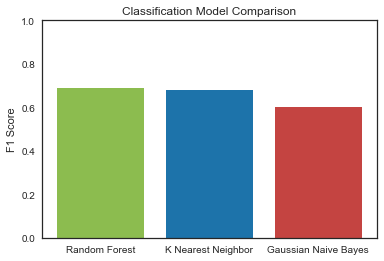

In [28]:
fig, ax = plt.subplots()
pm, pc, pn = plt.bar([1, 2, 3], [0.69, 0.68, 0.60])
pm.set_facecolor('#8CBC4F')
pc.set_facecolor('#1D73AA')
pn.set_facecolor('#C44441')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Random Forest', 'K Nearest Neighbor', 'Gaussian Naive Bayes'])
ax.set_ylim([0, 1])
ax.set_ylabel('F1 Score')
ax.set_title('Classification Model Comparison')

## Save the models.

In [29]:
saveModel(kNN_model, 'kNN')
saveModel(randomForest_model, 'randomForest')
saveModel(gaussianNB_model, 'gaussianNB')

kNN Model saved successfully.
randomForest Model saved successfully.
gaussianNB Model saved successfully.
